Find Players with low potentials but high actual Rating
- Label Players has a potential higher than 83 but never reaches this potential

In [1]:
HYPERTRAINING = False
CV = 5
SCORING = ''
CLASS_WEIGHTS = 'balanced'
EXPERIEMENT_NAME = "offense_potential_predictor_regression"
RUN_NAME = None
TARGET_OVERALL = 80

PLAYER_ATTRIBUTES = [ 'central','winger','offense','Finishing',  'ShortPassing', 'Volleys', 'Dribbling',  'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility',    'Reactions', 'Balance', 
                      'ShotPower', 'Jumping',  'LongShots', 'Positioning', 'Vision' ]
# PLAYER_ATTRIBUTES = [ 'Age' ,'Dribbling',  'FKAccuracy',  'BallControl','ShotPower','Positioning', 'Penalties' ]
PLAYER_ATTRIBUTES = [  'central','offense','Age','Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility', 'GKPositioning', 'GKReflexes', 'Composure', 'Defensive awareness', 'Reactions', 'Balance', 
                      'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Marking', 
                      'StandingTackleshooting_technique', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking']
PLAYER_ATTRIBUTES = ['Reactions', 'age_based_Stamina', 'Positioning', 'ShortPassing',  'Dribbling', 'BallControl',    'Aggression',   'Vision',  'SprintSpeed','shooting']
PLAYER_ATTRIBUTES = ['Crossing', 'Finishing','shooting_technique','mental'
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl',  'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Aggression',  'Positioning', 'Vision',
       'Penalties',  
        'youth_player', 'shooting', 
       'mental', 'physique', 'Speed', 'ball_handling', 'age_based_Reactions',
       'age_based_physique', 'age_based_shooting_technique',
       'age_based_Stamina', 'age_based_Positioning', 'age_based_Vision',
       'age_based_Finishing', 'age_based_BallControl']

PLAYER_ATTRIBUTES = [ 'age_based_shooting','shooting', 'ShortPassing','Dribbling',    'BallControl',
                     'SprintSpeed', 'Agility','Composure', 'Reactions', 
                       'age_based_Stamina', 'Aggression', 'Interceptions', 'Positioning', 'age_based_Vision']

PLAYER_ATTRIBUTES = [ 'shooting', 
       'mental', 'physique', 'Speed', 'ball_handling', 'age_based_Reactions',
       'age_based_physique', 'age_based_shooting_technique',
       'age_based_Stamina', 'age_based_Positioning', 'age_based_Vision',
       'age_based_Finishing', 'age_based_BallControl']


In [2]:
import os
import pandas as pd
import numpy as np
import sys
import os

def find_and_append_module_path():
    current_dir = os.getcwd()
    substring_to_find = 'statsfaction'
    index = current_dir.rfind(substring_to_find)
    
    if index != -1:
        # Extract the directory path up to and including the last "mypath" occurrence
        new_dir = current_dir[:index + (len(substring_to_find))]

        # Change the current working directory to the new directory
        os.chdir(new_dir)
        sys.path.append(new_dir)
        # Verify the new current directory
        print("New current directory:", os.getcwd())
    else:
        print("No 'mypath' found in the current directory")
find_and_append_module_path()
os.getcwd()

from src.sport_analytics.model.prepare import add_features_raw_datadf_raw
from src.sport_analytics.model.eval import plot_feature_importance,plot_shap_summary,plot_auc_curves

New current directory: c:\Users\Robert\Documents\Projekte\dev\statsfaction


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


### Get Data

In [3]:
sql_prime = """
SELECT max(Age) as prime_age,* FROM(SELECT MAX(Overall) AS PrimeOverall,*
  FROM fifa
  GROUP BY ID ) 
  GROUP BY ID
  order by PrimeOverall DESC;
"""

sql_potentials = f"""
SELECT min(Age) as potential_age,* FROM  (SELECT *,Potential as max_potential FROM fifa WHERE Potential>={TARGET_OVERALL})
GROUP BY ID
order by potential DESC;
"""



In [4]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import sqlite3
DATABASE_PATH = "data/sport_analytics/database/football.db"
# Step 1: Establish a database connection
conn = sqlite3.connect(DATABASE_PATH)

df_potentials = pd.read_sql_query(sql_potentials, conn)
df_prime = pd.read_sql_query(sql_prime, conn)

conn.close()

df_potentials = df_potentials.set_index(['ID'])
df_prime = df_prime.set_index(['ID'])

df_raw = df_potentials.join(df_prime[["prime_age","PrimeOverall"]])
df_raw = df_raw.reset_index(['ID'])
df_raw = add_features_raw_datadf_raw(df_raw)

df_raw.head()


,,,potential_age,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,...,ball_handling,age_based_Reactions,age_based_physique,age_based_shooting_technique,age_based_Stamina,age_based_Positioning,age_based_Vision,age_based_Finishing,age_based_BallControl,age_based_shooting
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,,
158023,L. Messi,2011,23.0,23.0,https://cdn.sofifa.net/players/158/023/11_60.png,Argentina,https://cdn.sofifa.net/flags/ar.png,90.0,95.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€0,...,94.2,15.742424,-4.863636,26.616667,1.750000,30.401515,22.386364,35.196970,25.765152,31.424242
20801,Cristiano Ronaldo,2011,25.0,25.0,https://cdn.sofifa.net/players/020/801/11_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,89.0,94.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€0,...,92.2,13.169643,8.799107,26.707143,10.535714,26.562500,9.500000,30.133929,23.366071,28.907738
244778,Trincão,2021,20.0,20.0,https://cdn.sofifa.net/players/244/778/21_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,78.0,91.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€34M,...,80.2,12.425926,9.250000,16.803704,9.037037,15.351852,15.092593,19.259259,14.574074,15.234568
183277,E. Hazard,2011,19.0,19.0,https://cdn.sofifa.net/players/183/277/11_60.png,Belgium,https://cdn.sofifa.net/flags/be.png,81.0,91.0,LOSC Lille,https://cdn.sofifa.net/meta/team/690/30.png,€0,...,83.0,11.125000,-0.210227,16.313636,6.477273,22.250000,21.750000,22.977273,18.102273,19.503788
243812,Rodrygo,2021,19.0,19.0,https://cdn.sofifa.net/players/243/812/21_60.png,Brazil,https://cdn.sofifa.net/flags/br.png,79.0,90.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€38M,...,83.2,17.019608,0.872549,23.164706,16.372549,28.725490,14.196078,28.137255,15.431373,28.457516


# 

In [5]:
df_raw.PrimeOverall

ID      Name               FIFA
158023  L. Messi           2011    94.0
20801   Cristiano Ronaldo  2011    94.0
244778  Trincão            2021    78.0
183277  E. Hazard          2011    91.0
243812  Rodrygo            2021    81.0
                                   ... 
20486   Carlinhos Bala     2011    69.0
193268  A. Gerbo           2011    65.0
189437  C. Pasquato        2011    74.0
135499  Dagoberto          2011    77.0
1551    L. Giuly           2011    76.0
Name: PrimeOverall, Length: 6400, dtype: float64

In [6]:
df = df_raw.copy()

year_to_category = {2011: 'drop', 2012: 'train', 2013: 'train', 2014: 'train', 2015: 'train', 2016: 'train', 2017: 'train', 2018: 'train', 2019: 'test', 2020: 'test', 2021: 'test', 2022: 'test', 2023: 'valid', 2024: 'valid'}
df['set'] = df.index.get_level_values('FIFA').values
# Apply the mapping to the "FIFA" column
df['set'] = df['set'].map(year_to_category)

df_potentials = df[(df.set=="valid")&(df.Overall<TARGET_OVERALL)&(df.Age<26)&(df.Potential>=TARGET_OVERALL)]

target
77.0    77
78.0    63
75.0    61
76.0    52
79.0    47
73.0    47
74.0    46
81.0    39
71.0    37
70.0    35
80.0    35
72.0    33
83.0    31
68.0    30
84.0    30
82.0    28
67.0    24
69.0    24
64.0    15
66.0    14
85.0    12
65.0    10
87.0     9
86.0     7
88.0     6
90.0     6
89.0     6
62.0     4
91.0     4
63.0     4
92.0     3
61.0     2
94.0     2
57.0     1
58.0     1
Name: count, dtype: int64


array([[<Axes: title={'center': 'potential_age'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Overall'}>,
        <Axes: title={'center': 'Potential'}>,
        <Axes: title={'center': 'Special'}>,
        <Axes: title={'center': 'Unnamed: 0'}>,
        <Axes: title={'center': 'Crossing'}>,
        <Axes: title={'center': 'Finishing'}>],
       [<Axes: title={'center': 'HeadingAccuracy'}>,
        <Axes: title={'center': 'ShortPassing'}>,
        <Axes: title={'center': 'Volleys'}>,
        <Axes: title={'center': 'Dribbling'}>,
        <Axes: title={'center': 'Curve'}>,
        <Axes: title={'center': 'FKAccuracy'}>,
        <Axes: title={'center': 'LongPassing'}>,
        <Axes: title={'center': 'BallControl'}>],
       [<Axes: title={'center': 'Acceleration'}>,
        <Axes: title={'center': 'SprintSpeed'}>,
        <Axes: title={'center': 'Agility'}>,
        <Axes: title={'center': 'Reactions'}>,
        <Axes: title={'center': 'Balance'}>,
        

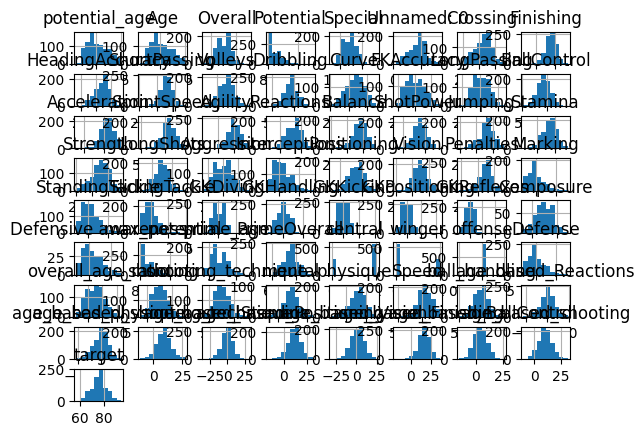

In [7]:

df = df[df.prime_age>df.potential_age]
df['target'] = df.PrimeOverall
df = df[df.potential_age<26]
df = df[df.offense>0.5]
print(df.target.value_counts())
PREDICTION_NAME = "Offense"

df_processed = df.copy()
df_processed.hist()

In [8]:
df_processed.best_position.value_counts()

best_position
ST    487
LW    141
RW    124
CF     75
RF     10
LF      8
Name: count, dtype: int64

In [9]:
df[["potential_age","Age","prime_age","max_potential","Potential","Overall","PrimeOverall","target","set","best_position"]].head()

,,,potential_age,Age,prime_age,max_potential,Potential,Overall,PrimeOverall,target,set,best_position
ID,Name,FIFA,,,,,,,,,,
158023,L. Messi,2011,23.0,23.0,24.0,95.0,95.0,90.0,94.0,94.0,drop,RW
20801,Cristiano Ronaldo,2011,25.0,25.0,31.0,94.0,94.0,89.0,94.0,94.0,drop,RW
183277,E. Hazard,2011,19.0,19.0,27.0,91.0,91.0,81.0,91.0,91.0,drop,RW
243812,Rodrygo,2021,19.0,19.0,21.0,90.0,90.0,79.0,81.0,81.0,test,RW
208790,Z. Bakkali,2014,17.0,17.0,20.0,90.0,90.0,73.0,74.0,74.0,train,RW


In [10]:
# if True:
#     df = df[[any(pos in i for pos in ['CF', 'LW', 'ST', 'RW']) for i in df['Position']]]
#     df.shape
# else:
#     select_position = lambda x: x in ["ST","CF","LW","RW"]
#     df["select"] = df['Position'].apply(select_position)
#     df = df[df["select"]]
#     df.shape

## Deskriptive Analyse

In [11]:
df.select_dtypes(exclude='object').corr()['target'].round(2).sort_values().head(100)

youth_player        -0.35
overall_age_ratio   -0.16
central             -0.07
GKPositioning       -0.03
GKReflexes          -0.02
                     ... 
Special              0.64
Overall              0.72
PrimeOverall         1.00
target               1.00
offense               NaN
Name: target, Length: 66, dtype: float64

In [12]:
df[df.Age<20].describe().round(0).compare(df[df.Age>=20].describe().round(0))

potential_age           Age        Overall        Potential         \
               self  other   self  other    self  other      self  other   
count         384.0  461.0  384.0  461.0   384.0  461.0     384.0  461.0   
mean           18.0   22.0   18.0   22.0    66.0   73.0       NaN    NaN   
std             1.0    2.0    1.0    2.0     4.0    5.0       NaN    NaN   
min            16.0   20.0   16.0   20.0    54.0   58.0       NaN    NaN   
25%            18.0   21.0   18.0   21.0    63.0   70.0      81.0   80.0   
50%            18.0   22.0   18.0   22.0    66.0   73.0       NaN    NaN   
75%            19.0   23.0   19.0   23.0    69.0   76.0       NaN    NaN   
max            19.0   25.0   19.0   25.0    81.0   90.0      91.0   95.0   

      Special          ... age_based_Vision        age_based_Finishing         \
         self   other  ...             self  other                self  other   
count   384.0   461.0  ...            384.0  461.0               384.0  461.0   
mean   1611.0  1795.0  ...              1.0    2.0                14.0   18.0   
std     120.0   133.0  ...              8.0    9.0                 NaN    NaN   
min    1303.0  1462.0  ...            -30.0  -27.0               -19.0  -10.0   
25%    1530.0  1711.0  ...             -5.0   -3.0                10.0   14.0   
50%    1594.0  1791.0  ...              1.0    3.0                14.0   19.0   
75%    1694.0  1877.0  ...              6.0    8.0                19.0   23.0   
max    1979.0  2316.0  ...             24.0   23.0                32.0   37.0   

      age_based_BallControl        age_based_shooting        target         
                       self  other               self  other   self  other  
count                 384.0  461.0              384.0  461.0  384.0  461.0  
mean                    4.0    6.0                8.0   12.0   74.0   78.0  
std                     NaN    NaN                NaN    NaN    6.0    5.0  
min                   -12.0  -15.0              -10.0   -9.0   57.0   65.0  
25%                    -0.0    1.0                4.0    8.0   69.0   75.0  
50%                     3.0    5.0                8.0   12.0   74.0   77.0  
75%                     8.0    9.0               12.0   16.0   78.0   81.0  
max                    21.0   26.0               28.0   31.0   91.0   94.0  

[8 rows x 130 columns]

###  Feature Engineering

#### Transform Value

In [13]:
df_processed = df_processed.fillna(0)
df_potentials = df_potentials.fillna(0)

<Axes: >

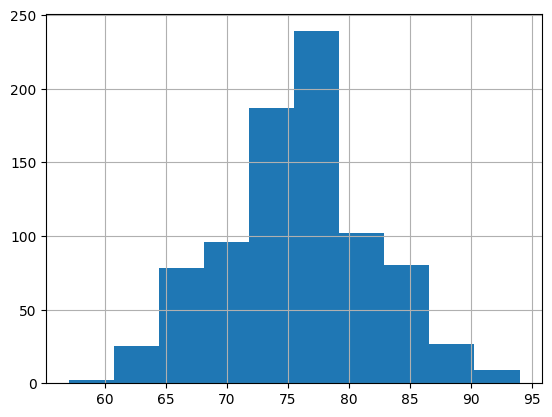

In [14]:
df['target'].hist()

In [15]:
X = df_processed.drop("target", axis=1, errors='ignore')
y = df['target']  # Use df_processed here instead of df
# Split the data into training and testing sets

In [16]:


from sklearn.model_selection import train_test_split
if False:
    # Step 1: Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train = X_train[PLAYER_ATTRIBUTES]
    X_test = X_test[PLAYER_ATTRIBUTES]

else:

    X_train = X[X.set=="train"][PLAYER_ATTRIBUTES]
    y_train = y[X.set=="train"]

    X_test = X[X.set=="test"][PLAYER_ATTRIBUTES]
    y_test = y[X.set=="test"]


In [17]:
y_train.describe()

count    383.000000
mean      76.671018
std        5.397922
min       57.000000
25%       73.000000
50%       77.000000
75%       80.000000
max       92.000000
Name: target, dtype: float64

In [18]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")
# Load your dataset or replace df_processed and df with your data
# df_processed = pd.read_csv('your_dataset.csv')

import pandas as pd

from sklearn.preprocessing import StandardScaler
# Step 2: Initialize a StandardScaler
scaler = StandardScaler()

# Step 3: Fit the scaler on the training data and transform both training 
# and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

df_potentials_scaled = scaler.transform(df_potentials[PLAYER_ATTRIBUTES].fillna(0))

# Step 4: Create new DataFrames with the scaled data while preserving the index and columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=PLAYER_ATTRIBUTES)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=PLAYER_ATTRIBUTES)
df_potentials_scaled_df = pd.DataFrame(df_potentials_scaled, index=df_potentials.index, columns=PLAYER_ATTRIBUTES)

# Hyperparametertuning

In [19]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 1, 8),
            'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),  # Adjust the range
            'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),  # Adjust the range
            'max_features': trial.suggest_float('max_features', 0.6, 1.0),
            'criterion': 'entropy',  # or 'entropy' depending on your problem
            'random_state': 42
        }

        # Implement cross-validation
        cv_scores = cross_val_score(RandomForestClassifier(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_auc = cv_scores.mean()

        return mean_auc

    # Create an Optuna study for maximizing AUC
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)  # You can increase n_trials for more optimization

    PARAMS_RF = study.best_params
    best_auc = study.best_value

    print("Best hyperparameters:", PARAMS_RF)
    print(f"Best {SCORING}:", best_auc)
else:
    PARAMS_RF = {}

In [20]:
import optuna
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'max_depth': trial.suggest_int('max_depth', 1, 12),
            'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),  # Adjust the range
            'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),  # Adjust the range
            'max_features': trial.suggest_float('max_features', 0.1, 1.0),
            'criterion': 'gini',  # or 'entropy' depending on your problem
            'random_state': 42
        }

        # Create the Decision Tree classifier with the given hyperparameters
        clf = DecisionTreeClassifier(**params)

        # Implement cross-validation to calculate mean AUC
        cv_scores = cross_val_score(clf, X_train_scaled_df, y_train, cv=CV, scoring='recall_macro')
        mean_auc = cv_scores.mean()

        return mean_auc

    # Create an Optuna study for maximizing AUC
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)  # You can increase n_trials for more optimization

    PARAM_DT = study.best_params
    best_auc = study.best_value

    print("Best hyperparameters:", PARAM_DT)
    print(f"Best {SCORING}:", best_auc)
else:
    PARAM_DT = {}

In [21]:
import optuna
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'objective': 'binary:logistic',
            'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.3),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'min_child_weight': trial.suggest_uniform('min_child_weight', 1.0, 20.0),
            'n_estimators': trial.suggest_int('n_estimators', 100, 300),
            'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
            'reg_alpha': trial.suggest_uniform('reg_alpha', 0.1, 1.0),
            'reg_lambda': trial.suggest_uniform('reg_lambda', 0.01, 0.1),
            'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        }
        # Implement early stopping with cross-validation
        cv_scores = []

        clf = XGBClassifier(**params, random_state=42, n_jobs=-1)
        # Implement cross-validation to calculate mean AUC
        cv_scores = cross_val_score(clf, X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_auc = cv_scores.mean()

        return mean_auc
    # Create an Optuna study for maximizing AUC
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)  # You can increase n_trials for more optimization

    PARAM_XGB = study.best_params
    best_auc = study.best_value

    print("Best hyperparameters:", PARAM_XGB)
    print(f"Best {SCORING}:", best_auc)
else:
    PARAM_XGB = {}


# TODOS
- SHAP Values for Regression Models
- Hyperparameter Tuning


Linear Regression training----->


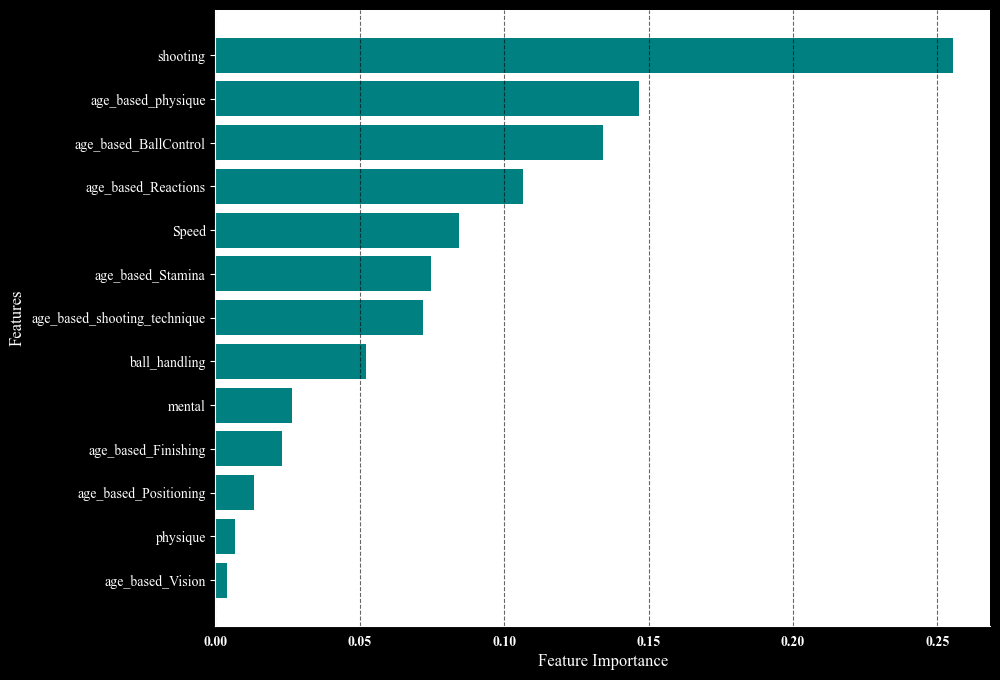

Model: Linear Regression
Mean Squared Error: 20.15
Mean Absolute Error: 3.63
R^2 Score: 0.34



In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb
from src.sport_analytics.model.eval import plot_feature_importance, log_metrics_in_mlflow_regression, log_feature_list_as_artifact, plot_shap_summary_regression
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.lightgbm
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# (Your other imports and parameters)

# Create and train different regression models
regression_models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=42),
    'Random Forest Regressor': RandomForestRegressor(random_state=42),
    'XGBoost Regressor': xgb.XGBRegressor(random_state=42),
    'LightGBM Regressor': lgb.LGBMRegressor(random_state=42)
}

regression_results = {}

# Set the experiment name
mlflow.set_experiment(EXPERIEMENT_NAME)

# Start MLflow run with a specific run name and description
for model_name, model in regression_models.items():
    with mlflow.start_run(run_name=RUN_NAME):

        print(model_name, "training----->")

        # Log parameters
        mlflow.log_param("Model_Name", model_name)
        mlflow.log_params(model.get_params())

        model.fit(X_train_scaled_df, y_train)
       
        y_pred = model.predict(X_test_scaled_df)
        
        # Log Params
        log_feature_list_as_artifact(PLAYER_ATTRIBUTES, filename="feature_list.txt")

        # Create a dictionary with parameters and their values
        params_to_log = {
            'HYPERTRAINING': HYPERTRAINING,
            'CV': CV,
            'SCORING': SCORING,
            'features_anzahl': len(PLAYER_ATTRIBUTES),
            # 'y_train_positives': y_train.sum(),
            # 'y_train_negatives': (~y_train).sum(),
            # 'y_test_positives': y_test.sum(),
            # 'y_test_negatives': (~y_test).sum(),
            'TARGET_OVERALL': TARGET_OVERALL
        }

        # Log parameters using log_params
        mlflow.log_params(params_to_log)

        # Log artifacts
        mlflow.sklearn.log_model(model, model_name)

        # Evaluation Plots (Note: Regression models may not have ROC curves, so adapt this as needed)
        # plot_auc_curves(y_true=y_test, y_proba=model.predict_proba(X_test_scaled_df))
        plot_feature_importance(model, '', top_n=20)
        plot_shap_summary(model=model,df=X_test_scaled_df,K = 30)

            
        # Evaluation Metrics
        log_metrics_in_mlflow_regression(y_test=y_test, y_pred=y_pred)

        # Output for quick evaluation
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        regression_results[model_name] = {
            'Model': model,
            'Attributes': PLAYER_ATTRIBUTES,
            'Mean Squared Error': mse,
            'Mean Absolute Error': mae,
            'R2 Score': r2
        }

# Evaluate and print results for each model
for model_name, results in regression_results.items():
    print(f"Model: {model_name}")
    print(f"Mean Squared Error: {results['Mean Squared Error']:.2f}")
    print(f"Mean Absolute Error: {results['Mean Absolute Error']:.2f}")
    print(f"R^2 Score: {results['R2 Score']:.2f}")
    print()


Using 234 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 25/25 [00:59<00:00,  2.37s/it]


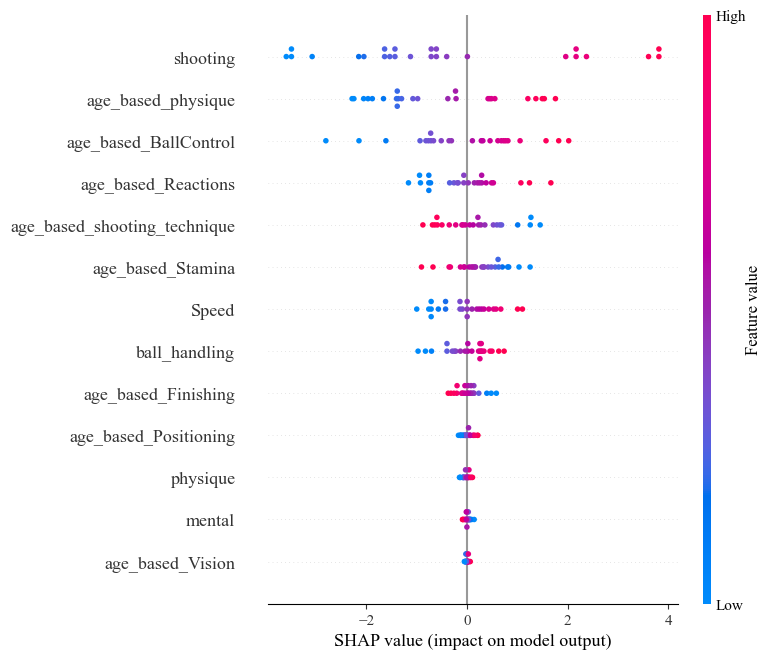

In [30]:
from src.sport_analytics.model.eval import plot_shap_summary
plot_shap_summary(model=model,df=X_test_scaled_df)

# evaluate Model

In [23]:
my_model = regression_results['Linear Regression']['Model']

true_positives = (my_model.predict(X_test_scaled_df)>=80)&(y_test>=80)
X_test_scaled_df[true_positives]



,,,shooting,mental,physique,Speed,ball_handling,age_based_Reactions,age_based_physique,age_based_shooting_technique,age_based_Stamina,age_based_Positioning,age_based_Vision,age_based_Finishing,age_based_BallControl
ID,Name,FIFA,,,,,,,,,,,,,
243812,Rodrygo,2021,2.014725,1.964606,-0.196827,1.039565,1.574826,2.557105,0.138063,2.243790,1.835777,2.443308,1.432372,1.636084,1.814659
255475,Antony,2021,1.377984,1.725268,0.003531,1.488008,1.950950,1.080924,0.064560,1.382172,1.021005,0.691391,1.769194,-0.007551,1.838533
240950,Pedro Gonçalves,2022,2.287614,2.032988,0.654694,-0.305764,1.719489,2.039584,-0.049819,2.611081,1.294572,2.203430,2.110917,2.127354,2.098000
241721,Rafael Leão,2020,1.014131,1.673982,0.855052,1.039565,-0.016468,1.440068,0.941806,1.523439,0.282333,1.753486,1.285533,1.456574,0.819006
239085,E. Håland,2020,0.286427,1.862033,1.355947,0.270805,-0.305794,2.203900,2.480887,1.489093,1.713966,1.469112,0.158501,0.958610,1.557887
231447,D. Malen,2020,0.559316,1.503026,1.005321,1.552071,0.967241,1.286198,1.118909,1.877022,0.948767,0.196055,0.820391,1.733327,1.320900
210315,De Tomás,2020,1.969244,1.862033,0.754873,-0.946397,0.214993,0.717904,0.662772,2.892340,-0.167880,1.741215,-1.055679,1.838493,1.207137
221479,D. Calvert-Lewin,2020,0.513834,1.708173,1.556305,0.655185,0.070330,0.907448,1.423666,1.133541,1.126306,1.926402,0.630285,0.910752,1.095772
207421,L. Trossard,2020,1.559910,1.981702,0.153800,0.591122,1.690556,-0.513057,-0.045637,2.538758,0.609626,1.174877,1.618884,1.700117,2.043628


In [24]:
false_positives = (my_model.predict(X_test_scaled_df)>=80)&(y_test<80)
X_test_scaled_df[false_positives]

,,,shooting,mental,physique,Speed,ball_handling,age_based_Reactions,age_based_physique,age_based_shooting_technique,age_based_Stamina,age_based_Positioning,age_based_Vision,age_based_Finishing,age_based_BallControl
ID,Name,FIFA,,,,,,,,,,,,,
247181,G. Plata,2021,0.013538,1.656886,0.153800,0.847375,1.082971,1.787754,0.551302,1.054465,0.613982,1.027462,1.432372,-0.162810,1.312765
245158,L. Suárez,2021,1.377984,1.571408,1.556305,0.975501,0.186060,1.054672,1.270991,1.323444,0.849101,1.072353,-0.322339,1.758412,-0.197455
216549,A. Sørloth,2021,1.377984,1.844937,2.107290,-0.497954,-0.855514,0.625582,1.644706,1.276573,0.994677,0.971939,0.727363,1.469490,0.560251
253004,Ansu Fati,2021,-0.077425,1.810746,-0.898080,1.167691,1.227634,1.816572,0.267108,0.376248,0.584092,-0.203051,0.695819,0.562567,1.188677
244193,Jovane Cabral,2021,1.423465,1.793651,0.304068,1.039565,1.140837,1.208543,-0.204862,1.869891,-0.150550,0.789184,1.073085,0.097894,0.973632


In [25]:
false_negatives= (my_model.predict(X_test_scaled_df)<80)&(y_test>80)
X_test_scaled_df[false_negatives]

,,,shooting,mental,physique,Speed,ball_handling,age_based_Reactions,age_based_physique,age_based_shooting_technique,age_based_Stamina,age_based_Positioning,age_based_Vision,age_based_Finishing,age_based_BallControl
ID,Name,FIFA,,,,,,,,,,,,,
241852,M. Diaby,2019,-1.441872,1.041446,-2.000048,0.334869,0.533252,-0.556053,-1.543806,-0.315211,-0.729544,-0.729085,0.563409,-0.711755,0.923798
235944,Brais Méndez,2019,0.650279,1.520122,0.504426,-1.074523,-0.334727,1.076935,0.493692,1.115030,0.200082,0.963952,1.191312,0.616523,0.756719
240243,Matheus Cunha,2019,-0.077425,1.434644,0.003531,0.398932,-0.942312,0.099056,0.628027,0.620678,0.619020,-0.269216,0.482759,-0.202456,-0.559731
236786,M. Terrier,2019,0.195464,1.588504,0.003531,0.014552,-0.045401,0.923064,-0.096649,0.632871,-0.244207,0.963952,1.540168,0.893276,0.254825
253072,D. Núñez,2021,0.741242,1.588504,0.304068,0.206742,-0.710851,-0.065124,0.075710,1.211571,-1.429168,0.402454,-1.717214,0.955959,-0.257651
240690,N. González,2019,-0.031944,1.537217,-0.096648,0.014552,0.012464,0.511812,-0.171577,-0.124317,0.163654,1.272270,0.590287,1.256474,0.087254
237679,R. Kolo Muani,2022,0.468353,1.537217,0.304068,0.462995,0.157128,0.255361,-0.165316,0.020818,-0.538121,0.371277,-0.524995,-0.014074,0.520708
232293,V. Osimhen,2019,-0.668685,1.349166,-0.246916,-0.305764,-0.884447,0.099056,0.332856,0.267095,-0.269559,0.155538,-0.796380,-0.064080,-0.392433
251892,Beto,2022,0.149982,1.656886,1.456126,-1.010460,-1.897088,0.347013,0.894727,0.650303,0.072776,1.070753,-0.912503,0.881966,0.257720


In [26]:
true_negatives= (my_model.predict(X_test_scaled_df)<80)&(y_test<80)
X_test_scaled_df[true_negatives]

,,,shooting,mental,physique,Speed,ball_handling,age_based_Reactions,age_based_physique,age_based_shooting_technique,age_based_Stamina,age_based_Positioning,age_based_Vision,age_based_Finishing,age_based_BallControl
ID,Name,FIFA,,,,,,,,,,,,,
246045,P. De la Vega,2020,-0.987056,1.263688,-0.096648,0.911438,0.677915,0.203589,0.768898,0.171192,1.158604,0.478020,0.274786,-0.701908,1.223290
246420,J. Doku,2020,-2.078613,1.109828,-2.601122,1.167691,0.967241,-1.056731,-1.570685,-0.975643,-0.767671,-0.741235,0.165317,-0.624608,1.608653
251873,Y. Demir,2021,-0.668685,1.075637,-2.350675,-1.010460,0.677915,-0.645350,-1.444882,-0.748788,-0.415559,-1.477313,-0.001893,-1.374703,0.352186
246682,K. Dembélé,2021,-1.032538,1.041446,-2.651212,0.911438,0.793645,-1.414700,-1.799086,-0.909508,-0.748776,-2.468405,-0.118178,-1.928209,-0.317007
246174,H. Elliott,2021,-1.441872,1.280784,-2.400764,-0.497954,0.157128,-0.029869,-1.503916,-1.873825,-0.970921,-1.052559,0.230678,-2.343339,-0.651603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250807,H. Dervişoğlu,2020,-1.441872,1.434644,-0.297006,-0.369827,-0.566188,0.462368,0.171815,-0.975113,0.607793,-0.185504,1.163184,-0.502398,0.256685
238196,A. Sigurðsson,2019,-1.714761,0.802108,-0.898080,-0.818270,-0.334727,-0.208685,-0.434587,-1.790115,-0.269559,-1.118724,-0.098668,-2.001350,-0.057837
220085,L. Waldschmidt,2020,1.423465,1.673982,0.003531,-0.305764,0.417521,0.488381,-0.614333,1.576047,-0.374290,1.112343,1.569463,0.644996,-0.239992
